### Einleitung

In diesem Notebook finden Sie eine Anleitung und erklärten Code, um alle Ressourcen (Bilder, Volltexte, PDFs) eines Zeitungsunternehmens herunterzuladen, die mit Visual Library gehostet werden.

Diese zweite Version gleicht in den Funktionen für den Download einer einzelnen Ausgabe der ersten Version (https://visuallibrary.net/static/public/OAI_METS_Download_Guide_1_DE.html), aber führt den Download für alle Ausgaben, die zu einem Zeitungsunternehmen gehören, durch. 

Als Beispiel dienen die Augsburger Postzeitung (Zeitungsunternehmen): https://visuallibrary.net/dps/periodical/titleinfo/436884?lang=de und die Kölnische Zeitung (Zeitung): https://zeitpunkt.nrw/ulbbn/periodical/titleinfo/9715712?lang=de.

Wir benutzen ein Python-Skript, um auf die öffentlich zugänglichen OAI/METS-Metadatensätze eines Zeitungsunternehmens zuzugreifen. Diese enthalten Metadaten über die Zeitungen, Jahrgänge und Ausgaben sowie strukturierte Informationen über die Dateien, die zu den einzelnen Ausgaben gehören.

Diese Anleitung setzt ein Grundverständnis von Python voraus, der Rest sollte hoffentlich durch die Erklärungen verständlich sein.

### Idee

In der Welt der Zeitungsunternehmen liegt üblicherweise die folgende hierarchische Struktur vor: Zeitungsunternehmen - Zeitung - Jahrgang - Ausgabe - Seite. Diese Struktur kann man als Baum repräsentieren. Die Wurzel ist ein Zeitungsunternehmen, in dem verschiedene Zeitungen publiziert wurden, welche daher als Kinder bezeichnet werden können. Jede Zeitung ist unterteilt in Jahrgänge, zu jedem Jahrgang gehören eine Reihe von Ausgaben (monatlich, wöchentlich, täglich, mehrmals täglich) und jede Ausgabe besteht aus mehreren Seiten. Insgesamt ergibt dies einen Baum mit fünf Ebenen, wobei die letzte Ebene die einzelen Seiten sind. Diese Baumstruktur ist auch in der folgenden Visualisierung sichtbar:

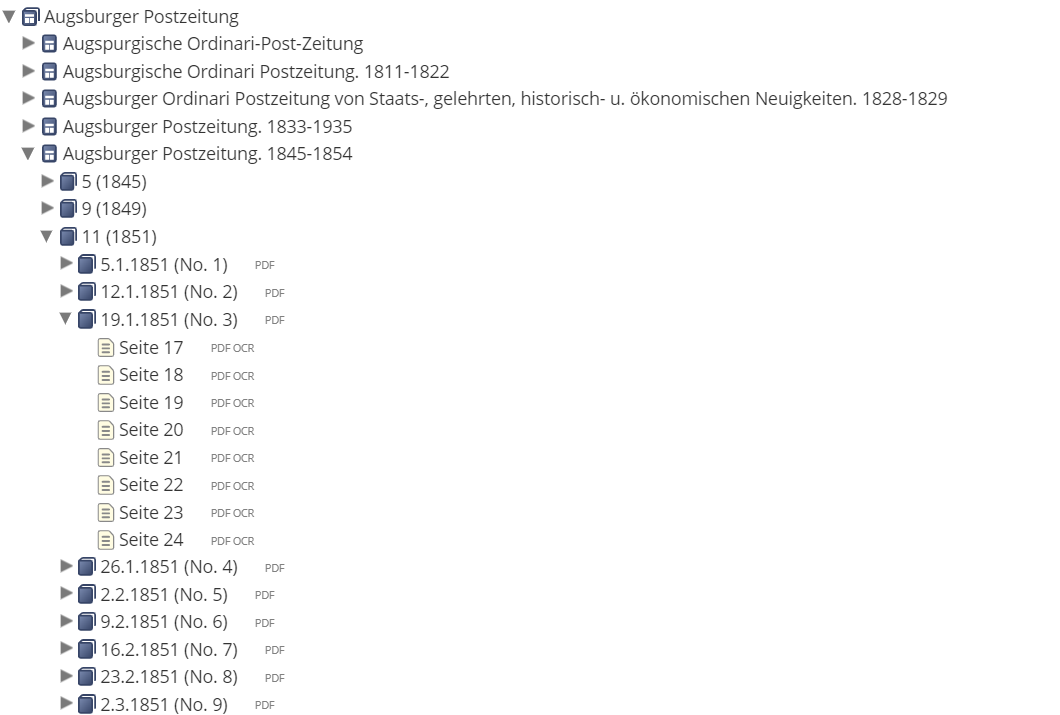

Jede der vier Ebenen überhalb der einzelnen Seiten wird duch einen OAI/METS-Datensatz repräsentiert, der Informationen über die dazugehörigen Kinder auf der nächstniedrigeren Ebene enthält. Wir werden den Baum 'traversieren', das heißt diese Struktur nutzen, um iterativ alle Elemente auf der nächstniedrigeren Ebene zu extrahieren. Dies führen wir für alle Elemente auf allen Ebenen durch, bis wir schließlich die Einzelseiten erreichen, welche wir dann herunterladen.

Das OAI-Format wird benutzt, um Metadaten in standardisierter Form auszutauschen. In unserem Fall enthält es hierarchische Metadaten im METS-Format. Spezifischere Metadaten für einzelne Elemente (Zeitungen, Ausgaben, Seiten, etc.) sind ebenfalls im METS-Datensatz enthalten und liegen im MODS-Format vor. Alle drei Formate basieren auf XML und weisen deren typische Baumstruktur auf. Wir werden ausschließlich mit den METS-Elementen arbeiten, welche hier definiert sind: https://dfg-viewer.de/fileadmin/groups/dfgviewer/METS-Anwendungsprofil_2.3.1.pdf.
Da wir die für uns relevanten Teile der Datensätze direkt mit XPath-Abfragen adressieren, ist ein tieferes Verständnis des METS-Standards hilfreich, aber nicht nötig.

Als Einstiegspunkt brauchen wir einen OAI/METS-Datensatz, der ein Zeitungsunternehmen oder eine Zeitung repräsentiert. Ein Link zu einem solchen Datensatz steht üblicherweise auf der Website, welche Zugang zu der Zeitung ermöglicht. Die Kölnische Zeitung ist zum Beispiel über zeitpunkt.nrw zugänglich und der OAI/METS-Datensatz kann in dem Abschnitt "Links" gefunden werden:

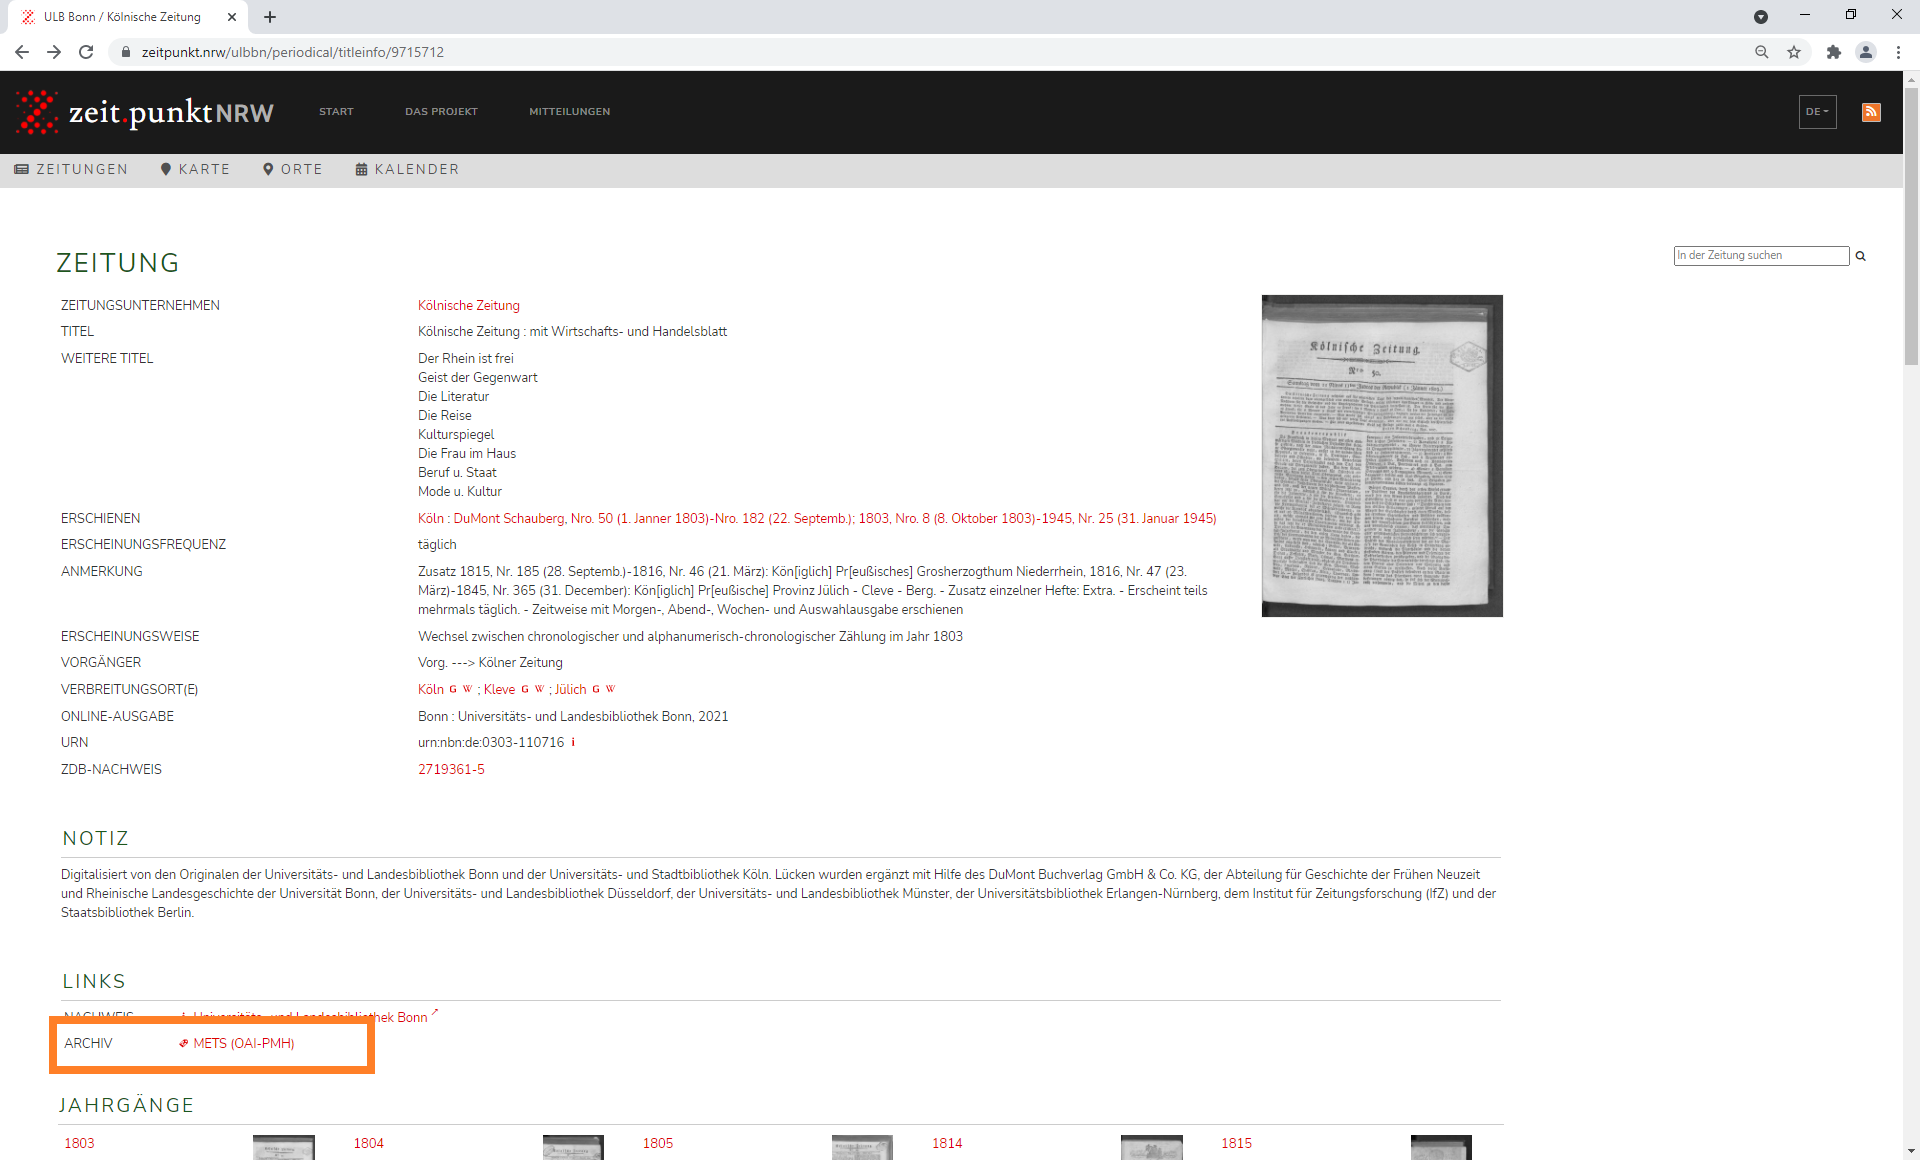

Beachten Sie, dass dieser Datensatz für die Darstellung im Browser optimiert ist. Um die maschinenlesbare Version zu erhalten, muss der "&mode=view"-Teil am Ende der URL entfernt werden. So erhalten wir den Link zum OAI/METS-Datensatz der Kölnischen Zeitung: https://zeitpunkt.nrw/ulbbn/oai/?verb=GetRecord&metadataPrefix=mets&identifier=9715712.

Im Weiteren werden wir jedoch die Augsburger Postzeitung als Beispielunternehmen nehmen, da sie aus mehreren verschiedenen Zeitungen besteht (also strukturreicher ist) und gleichzeitig insgesamt weniger Ausgaben vorliegen (also weniger Downloads nötig sind). Der Link zum OAI/METS-Datensatz ist folgender: https://visuallibrary.net/dps/oai/?verb=GetRecord&metadataPrefix=mets&identifier=436884.

### Code für Traversion und Download

Wir benutzen die lxml-Bibliothek, um mit den XML-Strukturen zu arbeiten, und die Bibliothek requests, um die Datensätze und Dateien aus dem Internet zu erhalten. Falls Sie diese noch nicht installiert haben, müssen Sie dies zunächst einmalig tun. (Dafür einfach die Raute (#) an den Zeilenanfängen entfernen.)

In [ ]:
# %pip install lxml
# %pip install requests

Wir importieren die Bibliotheken und die Funktionen, die wir benutzen werden.

In [ ]:
from io import StringIO
from mimetypes import guess_extension
from os import makedirs, path
from lxml import etree
import requests

Wir spezifizieren die URL der Zeitung, mit der wir arbeiten werden (Augsburger Postzeitung).

In [ ]:
url = 'https://visuallibrary.net/dps/oai/?verb=GetRecord&metadataPrefix=mets&identifier=436884'

Wir definieren die Funktion get_root. Diese lädt zunächst den Datensatz in unser Programm, parst ihn anschließend für die einfache Weiterverarbeitung als XML-Baum und extrahiert zuletzt den Wurzelknoten des Baums, welchen wir für die weiteren Operationen (XPath-Abfragen) brauchen.

In [ ]:
def get_root(url):
    """Get the root node as lxml node from a url, return lxml node."""
    r = requests.get(url)
    tree = etree.parse(StringIO(r.text))
    root = tree.getroot()
    return root

Im Folgenden verwenden wir XPath-Abfragen (https://www.w3schools.com/xml/xpath_intro.asp), um die Abschnitte, bzw. XML-Elemente zu finden, die wir aus dem Datensatz benötigen. XML-Dokumente benutzen häufig Namensräume (https://www.w3schools.com/xml/xml_namespaces.asp), um Namenskollisionen zwischen Variabelnamen zu verhindern. Diese Namensraum-Referenzen stehen am Anfang des Datensatzes. Wir werden sie für die XPath-Abfragen brauchen und speichern sie daher in einer Variablen.

In [ ]:
ns_map = {'xmlns': "http://www.openarchives.org/OAI/2.0/",
          'mets': "http://www.loc.gov/METS/",
          'xlink': "http://www.w3.org/1999/xlink"}

Nun definieren wir vier Funktionen, die alle nach dem gleichen Prinzip funktionieren. Wir starten mit der URL eines OAI/METS-Datensatzes und extrahieren die Links zu den Elementen der nächsten Ebene. Starten wir also beispielsweise mit einem Zeitungsunternehmen, extrahieren wir die Links zu allen Zeitungen; starten wir mit einer Ausgabe, extrahieren wir die Links zu allen Seiten. Wir tun dies jeweils mithilfe einer XPath-Abfrage. In den ersten drei Fällen nutzen wir das "mets:structMap"-Element als Einstiegspunkt, im letzten Fall (Ausgabe) das "mets:fileGrp"-Element. (Wenn Sie besser vestehen möchten, was die Struktur und der Zweck dieser XML-Elemente ist, können Sie einen OAI/METS-Datensatz in Ihrem Browser öffnen, wie gewohnt nach dem Namen des betreffenden Elements suchen und sich so einen Überblick verschaffen.) Eine ausführlich Erklärung und Dokumentation des verwendeten METS-Standards finden Sie hier: https://dfg-viewer.de/fileadmin/groups/dfgviewer/METS-Anwendungsprofil_2.3.1.pdf

In [ ]:
def get_newspapers_from_newspaper_series(url):
    root = get_root(url)
    newspaper_links = root.xpath('//mets:structMap//@xlink:href', namespaces=ns_map)
    return newspaper_links

def get_years_from_newspaper(url):
    root = get_root(url)
    year_links = root.xpath('//mets:structMap//@xlink:href', namespaces=ns_map)
    return year_links

def get_issues_from_year(url):
    root = get_root(url)
    issue_links = root.xpath('//mets:structMap//*[@TYPE="day"]//@xlink:href', namespaces=ns_map)
    return issue_links

Beachten Sie, dass die erste Funktion nicht gebraucht wird, wenn nicht mit einem Zeitungsunternehmen, sondern direkt mit einer einzelenen Zeitung gestartet wird. Der Rückgabewert der get_newspapers_from_newspaper_series-Funktion ist eine Liste mit Links zu Zeitungen. Das heißt der Start mit einer einzelen Zeitung ist äquivalent zu der Definition einer Liste mit nur einem Link, die dann der get_years_from_newspaper-Funktion übergeben wird.

Wenn wir die Ebene der Ausgaben erreichen, können wir schließlich die URLs aller Seiten dieser Ausgaben extrahieren. Üblicherweise gehören mehrere Ressourcen zu einer einzelnen Seite, das heißt sie liegt in verschiedenen Formaten vor. Es gibt immer ein JPEG-Bild der Seite, meistens in verschiedenen Auflösungen (im OAI/METS-Datensatz genannt: Max, Default, Min, Thumbs). Außerdem meistens eine Repräsentation des Texts der Seite (Alto-Format, genannt: Fulltext). Manchmal gibt es eine Textrepräsentation im HTML-Format (ebenfalls: Fulltext). Selten gibt es ein PDF mit dem Bild der Seite, meistens gibt es dagegen ein PDF mit den Bildern aller Seiten einer Ausgabe (genannt: Download).
Da im Datensatz die Links zu den Seiten für jedes Format zusammen stehen, müssen wir vor Ausführen der Funktion entscheiden, welches Format wir herunterladen möchten und das entsprechende Argument im fmt-Parameter übergeben. Um die Funktion intern möglichst simpel zu halten, kann bei jedem Aufruf nur ein Format übergeben werden. (Der Download mehrerer Formate wird dann mit mehreren Aufrufen erledigt, siehe unten.)

In [ ]:
def get_pages_from_issue(url, fmt='Fulltext'):
    """Get pages from an issue-url, provide format which should be extracted, return list of links to pages."""
    root = get_root(url)
    page_links = root.xpath(f'//mets:fileGrp[@USE="{fmt.upper()}"]//@xlink:href', namespaces=ns_map)
    return page_links

Nachdem wir die Links zu den Seiten extrahiert haben, möchten wir sie schließlich herunterladen. In der folgenden download_page-Funktion können wir einen Verzeichnis-Pfad angeben, an dem die Dateien gespeichert werden sollen. Anschließend lädt die Funktion die Datei herunter, ermittelt den Dateityp und extrahiert die ID-Nummer der Seite als Dateinamen. Die Dateinamen für verschiedene Seiten desselben Formats (z.B. JPEG) werden für verschiedene Versionen des Formats (z.B. Max, Default, Min, Thumbs) gleich sein. Das heißt, dass beim Download mehrerer Versionen eines Formats die letzte Version die vorherigen überschreibt. In diesem Fall wird eine Warnnachricht ausgegeben, aber das Überschreiben findet trotzdem statt. Letztendlich sollte dieses Skript also nicht ohne Änderungen genutzt werden, um verschiede Versionen desselben Formats im selben Durchgang herunterzuladen.

In [ ]:
def download_page(page_link, download_path='downloads'):
    """Extract name and filetype from link to newspaper page. Then save at specified folder."""
    try:
        makedirs(f'{download_path}')
    except FileExistsError:
        pass

    r = requests.get(page_link)
    ressource_name = page_link.split('/')[-1]

    # get rid of encoding if provided in r.headers; if not provided: split still works, then guess extension
    filetype = guess_extension(r.headers['Content-Type'].split(';')[0])
    filename = ressource_name + filetype
    
    # throw warning if file will be overwritten
    if path.isfile(f'{download_path}/{filename}'):
        print(f'Warning: {filename} already existed and was overwritten')

    # save file
    with open(f'{download_path}/{filename}', 'wb') as file:
        file.write(r.content)

Wir haben nun alle Bestandteile zusammen, um automatisiert ein ganzes Zeitungsunternehmen zu traversieren. Wir müssen bloß entscheiden, welche Formate wir herunterladen möchten. Hier ist die Liste aller Formate auskommentiert, damit nicht versehentlich (sehr) viele Downloads gestartet werden. Dies kann jedoch natürlich nach Bedarf angepasst werden. Ohne Änderung wird also nur das Bild jeder Seite in maximaler Auflösung heruntergeladen, was jedoch immer noch lange dauern kann, da die Bilder typischerweise zwei bis fünf Megabyte groß sind.

In [ ]:
# formats = ['Fulltext', 'Min', 'Thumbs', 'Default', 'Max', 'Download']
formats = ['Max']

In [ ]:
for newspaper in get_newspapers_from_newspaper_series(url):
    for year in get_years_from_newspaper(newspaper):
        for issue in get_issues_from_year(year):
            for f in formats:
                for page in get_pages_from_issue(issue, fmt=f):
                    download_page(page, download_path='downloads')

### Ergebnis

Wird der Code so wie er ist ausgeführt, wird ein Ordner namens "downloads" im Verzeichnis, in dem sich dieses IPYNB-Dokument befindet, angelegt. In diesen Ordner werden die Bilder aller Seiten aller Zeitungen, die zum Unternehmen Augsburger Postzeitung gehören, heruntergeladen. Dies sind circa 6750 Bilder, mit einer Gesamtgröße von circa 22 Gigabyte. Auf dem Testcomputer hat dies circa 1.5 Stunden gedauert. Führen Sie diesen Code unverändert also nur aus, wenn dies das von Ihnen gewünschte Ergebnis ist. Zu Testzwecken könnten Sie auch das Format zu 'Fulltext' ändern, sodass wesentlich kleinere Dateien heruntergeladen würden, in entsprechend kürzerer Zeit.